
<div dir=ltr align=center>

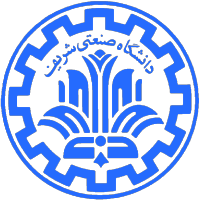

<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Fall 2025 <br>
<font color=3C99D size=5>
    Supervised Learning: Random Forest <br>
<font color=696880 size=4>
Prepared by Alireza Mirshafieian

____

# Student Information

In [ ]:
student_number = '402105998'
full_name = 'Faraz Doagooye Tehrani'

# Titanic Survival Prediction
Welcome to this hands-on machine learning tutorial using the famous **Titanic dataset**! In this notebook, we'll walk through the process of utilizing a **Random Forest Classifier** to predict passenger survival.

The Titanic disaster claimed 1,502 lives, but survival was not a matter of chance alone. Using real passenger data—including class, gender, and age—this project challenges you to build a predictive model that answers a key question: which passengers were most likely to survive?

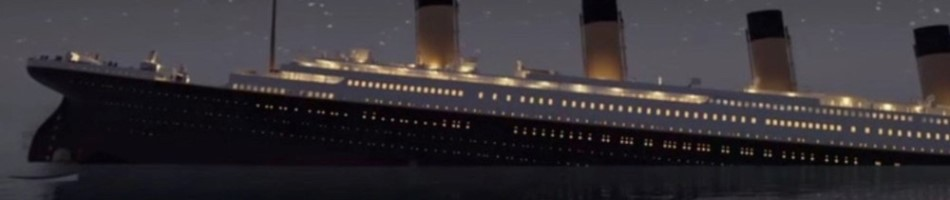

## 1️⃣ Import Libraries
Let's start by importing the essential Python libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## 2️⃣ Load the Titanic Dataset
We'll use the Titanic dataset from Kaggle. It contains passenger details like age, gender, class, and whether they survived. We'll start by loading the training data.

In [78]:
titanic_data = pd.read_csv('titanic.csv')

print("Dataset Shape:", titanic_data.shape)
titanic_data.head()


Dataset Shape: (891, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN


# Data Dictionary

| Variable | Definition | Key |
| :--- | :--- | :--- |
| `survival` | Survival | 0 = No, 1 = Yes |
| `pclass` | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| `sex` | Sex | |
| `Age` | Age in years | |
| `sibsp` | # of siblings / spouses aboard the Titanic | |
| `parch` | # of parents / children aboard the Titanic | |
| `ticket` | Ticket number | |
| `fare` | Passenger fare | |
| `cabin` | Cabin number | |

## Variable Notes

**pclass**: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

**age**: Age is fractional if less than 1.

## 3️⃣ Explore the Dataset
Before building a model, we need to **explore the data**. This helps us understand missing values, feature types, and distributions.

In [5]:
print(titanic_data.info())
print(titanic_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
dtype: int64


As you can see, the "Cabin" feature has a lot of missing values. Perhaps it will be best if we ignore that feature completely. "Age" also has some missing values, but the information it offers may be too valuable to discard. We'll have to figure out what to do with it later.

## 4️⃣ Data Visualization
Visualizations help us spot trends and relationships in the data. Let's look at survival rates by gender, class, and age.

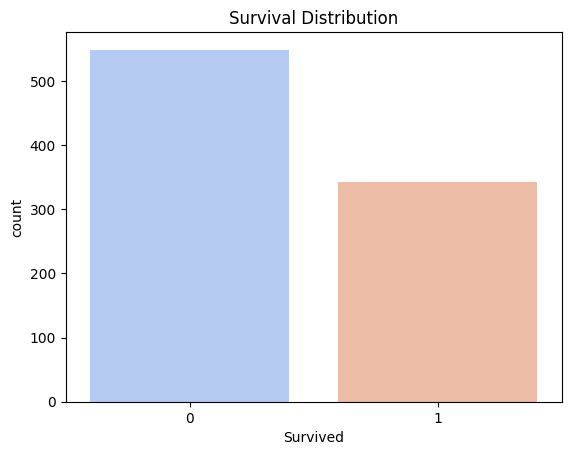

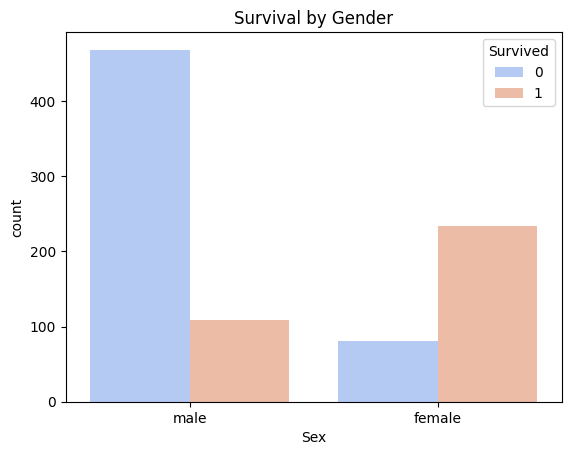

In [7]:
sns.countplot(data=titanic_data, x='Survived', palette='coolwarm')
plt.title('Survival Distribution')
plt.show()

sns.countplot(data=titanic_data, x='Sex', hue='Survived', palette='coolwarm') #td
plt.title('Survival by Gender')
plt.show()

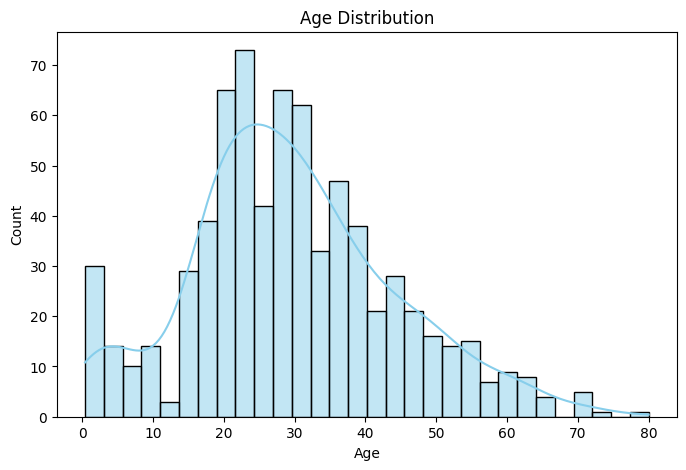

In [10]:
plt.figure(figsize=(8,5))
sns.histplot(data=titanic_data, x='Age', bins=30, kde=True, color='skyblue')

plt.title('Age Distribution')
plt.show()

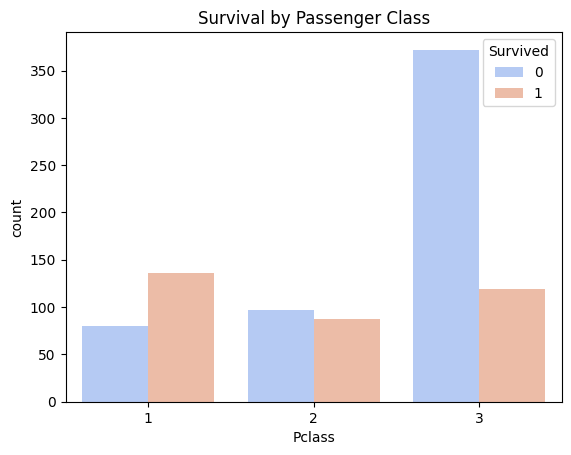

In [12]:
# TODO: Plot survival counts grouped by passenger class (Pclass)
sns.countplot(titanic_data, x='Pclass', hue='Survived', palette='coolwarm')
plt.title('Survival by Passenger Class')
plt.show()

Let's create a **heatmap** that visualizes the **correlation** between all numeric features in the dataset.

**Correlation** measures how strongly two numerical variables are related:
- **+1** → strong positive relationship (as one increases, the other also increases)  
- **-1** → strong negative relationship (as one increases, the other decreases)  
- **0** → no **linear** relationship

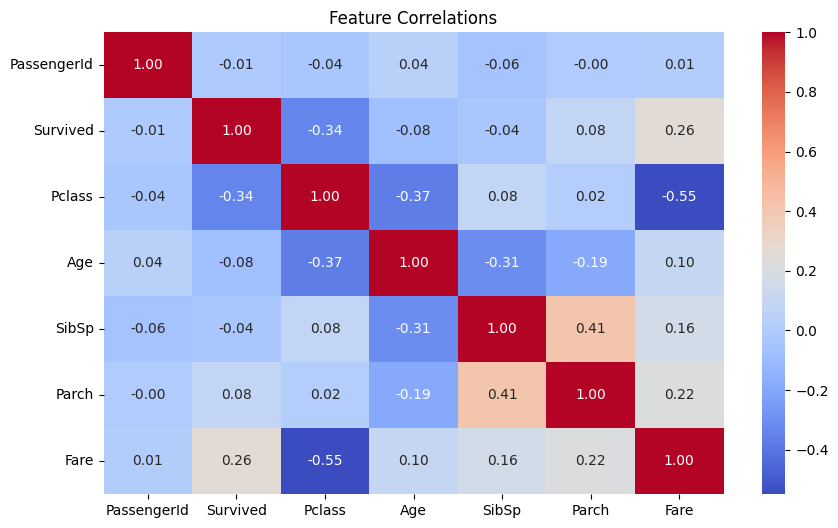

In [18]:
plt.figure(figsize=(10,6))

corr_matrix = titanic_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Feature Correlations')
plt.show()

As you can see, PassengerId has almost no correlation with other features. This was expected as PassengerId is simply the index that we've given the passengers in our dataset.

You can see that Pclass and fare seem to be highly correlated, as one would expect.

## 5️⃣ Data Preprocessing
We'll clean and prepare the data for modeling:
- Drop rows with missing target values
- Encode the `Sex` column (male=1, female=0)
- Fill missing `Age` values with the median. You can try other methods.
- Split into training and testing sets. We will use the testing set to evaluate our model.

In [84]:
titanic_data_copy = titanic_data.copy()
titanic_data_copy = titanic_data_copy.dropna(subset=['Survived'])

titanic_data_copy['Sex'] = titanic_data_copy['Sex'].map({'female': 0, 'male': 1})


titanic_data_copy['Age'] = titanic_data_copy['Age'].fillna(titanic_data_copy['Age'].median())

X = titanic_data_copy[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = titanic_data_copy['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
373,1,1,22.0,0,0,135.6333
571,1,0,53.0,2,0,51.4792
108,3,1,38.0,0,0,7.8958
491,3,1,21.0,0,0,7.2500
806,1,1,39.0,0,0,0.0000


## 6️⃣ Model Training — Random Forest Classifier
A **Random Forest** is an ensemble model made up of many decision trees. It’s robust, handles nonlinear relationships well, and reduces overfitting.

In [85]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

## 7️⃣ Model Evaluation
We'll measure how well our model performs using accuracy, a confusion matrix, and a classification report.

In [88]:
correct = sum(y_pred == y_test)
total = len(y_pred)
accuracy = correct / total
print(f"✅ Accuracy: {accuracy:.2f}")

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

✅ Accuracy: 0.84

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       107
           1       0.85      0.72      0.78        72

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



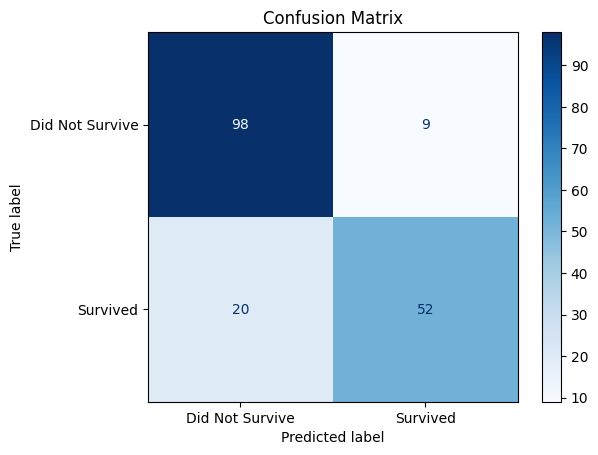

In [89]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Survive', 'Survived'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Explain what a confusion matrix is and how it can help us evaluate our model.

**>>WRITE YOUR ANSWER HERE**

. It gives us the values of TP, FP, FN, TN which tells us how our model's performance was and what the predicted labels were in comparison to the actual labels.
From it we can calculate many different evaluation metrics such as accuracy, recall, precision, etc.


## 8️⃣ Feature Importance Visualization
Random Forests can show us which features are most important for prediction.

At its core, feature_importances_ from a scikit-learn Random Forest is a normalized metric that quantifies the mean decrease in impurity (specifically, Gini Impurity or Entropy for classification, MSE for regression) averaged across all trees in the forest, attributable to each feature.

It answers: "When making decisions across all the trees in this forest, which features were most frequently and most effectively used to create pure nodes, thereby driving the predictive accuracy?"

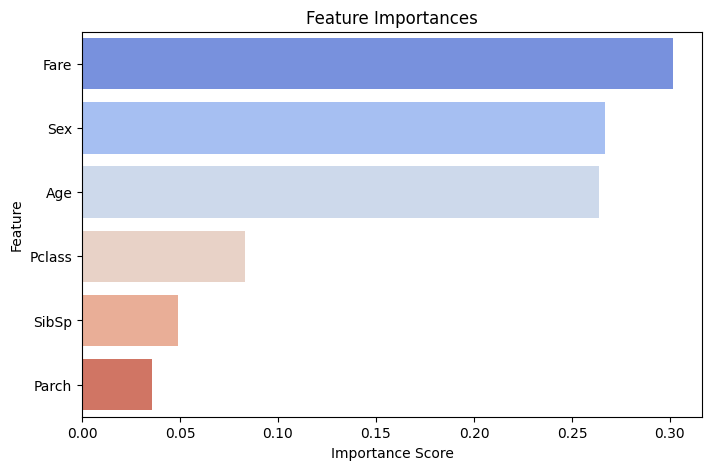

In [90]:
importances = rf_classifier.feature_importances_

features = X.columns

indices = importances.argsort()[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=features[indices], palette='coolwarm')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## 9️⃣ Try a Sample Prediction
Let's test our model on a single passenger from the test set to see whether they would survive.

In [93]:
sample = X_test.iloc[0:1]
true_value = y_test.iloc[0]
prediction = rf_classifier.predict(sample)

sample_dict = sample.iloc[0].to_dict()

print(f"\nSample Passenger: {sample_dict}")
print(f"Predicted Survival: {'🟢 Survived' if prediction[0] == 1 else '🔴 Did Not Survive'}")
print(f"True Survival: {'🟢 Survived' if true_value == 1 else '🔴 Did Not Survive'}")


Sample Passenger: {'Pclass': 3.0, 'Sex': 1.0, 'Age': 21.0, 'SibSp': 0.0, 'Parch': 0.0, 'Fare': 7.925}
Predicted Survival: 🔴 Did Not Survive
True Survival: 🔴 Did Not Survive


## 🎯 Well Done!
Eager for more? Head over to the Kaggle competition to test your skills, build more accurate models, and see how you rank on the leaderboard! Here is the link:

https://www.kaggle.com/c/titanic